<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/emojify%20sentences%20using%20word%20embedding/emojify_sentences_using_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Emojify Sentences using Word Embedding**

We will build a model using word embeddings.

In [ ]:
pip install emoji==1.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import emoji
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
# helper function

def read_csv(filename = "data/emojify_data.csv"):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [ ]:
emoji_dictionary = {#"0": ":red_heart:",    # :heart: prints a black instead of red heart depending on the font
                    "0": "\u2764\ufe0f",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):

    # Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
 

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
def predict(X, Y, W, b, word_to_vec_map):

    # Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of model over the given set
    
    # Arguments:
    # X -> input data containing sentences, numpy array of shape (m, None)
    # Y -> labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    # Returns:
    # pred -> numpy array of shape (m, 1) with your predictions

    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        
        if count > 0:
            avg = avg / count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print(f"Accuracy: {str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:])))}")
    
    return pred

In [ ]:
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

In [ ]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

**Dataset**

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence


The dataset is splitted between training (127 examples) and testing (56 examples).


In [ ]:
# loading dataset

X_train, Y_train = read_csv("/content/train_emoji.csv")
X_test, Y_test = read_csv("/content/tesss.csv")

In [ ]:
maxLen = len(max(X_train, key=len).split())

Printing sentences from X_train and corresponding labels from Y_train

In [ ]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


**Inputs and Outputs**
* The input of the model is a string corresponding to a sentence 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from)
* The (1,5) probability vector is passed to an argmax layer which extracts the index of the emoji with the highest probability


**One-hot Encoding**
* To get our labels into a format suitable for training a softmax classifier, converting $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [ ]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]} which is emoji {label_to_emoji(Y_train[idx])}")
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0 which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


**Implementing Emojifier**

The first step is to:
* Convert each word in the input sentence into their word vector representations
* Take an average of the word vectors 

We'll use pre-trained 50-dimensional GloVe embeddings. 



In [ ]:
# loading the `word_to_vec_map` which contains all the vector representations

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/MyDrive/colab files/glove.6B.50d.txt")

Here:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation


In [ ]:
word = "cucumber"
idx = 289846
print(f"the index of {word} in the vocabulary is {word_to_index[word]}")
print(f"the {str(idx)}th word in the vocabulary is {index_to_word[idx]}")

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


**Implement `sentence_to_avg()`** 

We'll need to carry out two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words. 
    * `X.lower()` and `X.split()` might be useful. 😉
2. For each word in the sentence, access its GloVe representation.
    * Then take the average of all of these word vectors.
    * We might use `numpy.zeros()`

    * When creating the `avg` array of zeros, we'll want it to be a vector of the same shape as the other word vectors in the `word_to_vec_map`.  
    * We can choose a word that exists in the `word_to_vec_map` and access its `.shape` field.


We can use any one of the word vectors that we retrieved from the input `sentence` to find the shape of a word vector.

In [ ]:
# sentence to avg

def sentence_to_avg(sentence, word_to_vec_map):
    
    # Arguments:
    # sentence -> string, one training example from X
    # word_to_vec_map -> dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    # Returns:
    # avg -> average vector encoding information about the sentence, numpy-array of shape (J,) where J can be any number


    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Step 1: Split sentence into list of lower case words 
    words = (sentence.lower()).split()
    
    # Initialize the average word vector that should have the same shape as your word vectors
    avg = np.zeros((word_to_vec_map['a'].shape))
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors. We can loop over the words in the list "words"
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg / count
    
    
    return avg

**Implement The Model**

We have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters


* The equations we need to implement in the forward pass and to compute the cross-entropy cost are below:
 

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$



In [ ]:
# model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    
    # Arguments:
    # X -> input data, numpy array of sentences as strings of shape (m, 1)
    # Y -> labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    # word_to_vec_map -> dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    # learning_rate -> learning_rate for the stochastic gradient descent algorithm
    # num_iterations -> number of iterations
    
    # Returns:
    # pred -> vector of predictions, numpy-array of shape (m, 1)
    # W -> weight matrix of the softmax layer of shape (n_y, n_h)
    # b -> bias of the softmax layer of shape (n_y,)

    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer 
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.sum(Y_oh[i] * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print(f"Epoch: {str(t)} --- cost = {str(cost)}")
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

Training the model and learning the softmax parameters (W, b)

In [ ]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.514551646342196
Accuracy: 0.45454545454545453
Epoch: 100 --- cost = 0.07193276890237922
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.041940843875099776
Accuracy: 0.946969696969697
Epoch: 300 --- cost = 0.032938930162471305
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.

Performance on test Set 

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print("Test set:")
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.875


Random guessing would have had 20% accuracy. Given that there are 5 classes. (1/5 = 20%). This is pretty good performance after training on only 127 examples. 

In the training set, the algorithm saw the sentence "I love you." with the label ❤️. 
The word "cherish" does not appear in the training set, let's see what happens if we write "I cherish you".

In [ ]:
X_my_sentences = np.array(["i cherish you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i cherish you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 


**Word Ordering isn't Considered in This Model**

The model doesn't get the following sentence correct:"not feeling happy". This algorithm ignores word ordering, so is not good at understanding phrases like "not happy". 

**Confusion Matrix**
* Printing the confusion matrix can also help understand which classes are more difficult for the model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️   ⚾  😄   😞  🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            1    0   17    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          8    9   20   13    6   56


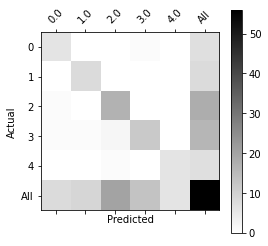

In [ ]:
print(Y_test.shape)
print(f"           {label_to_emoji(0)}   {label_to_emoji(1)}  {label_to_emoji(2)}   {label_to_emoji(3)}  {label_to_emoji(4)}")
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

This model just averages all the word embedding vectors together without considering the order of words.